In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from linearmodels import PanelOLS, RandomEffects
from linearmodels.panel import compare
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import arviz as az
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [3]:
total_data = pd.read_csv('MHI_data_filled.csv')
total_data

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,0,0,0,0,0,Severna i yugoiztochna Bulgaria,2011,10.96,30613.0,0.3635
1,1,1,1,1,1,1,Severozapaden,2011,10.56,5879.0,0.3500
2,2,2,2,2,2,2,Severen tsentralen,2011,9.27,6396.0,0.3635
3,3,3,3,3,3,3,Severoiztochen,2011,10.34,8677.0,0.3850
4,4,4,4,4,4,4,Yugoiztochen,2011,13.28,9660.0,0.4550
...,...,...,...,...,...,...,...,...,...,...,...
75,75,75,75,75,75,75,Severoiztochen,2020,9.24,12164.0,0.2860
76,76,76,76,76,76,76,Yugoiztochen,2020,10.29,12498.0,0.3380
77,77,77,77,77,77,77,Yugozapadna i yuzhna tsentralna Bulgaria,2020,5.75,78645.0,0.3635
78,78,78,78,78,78,78,Yugozapaden,2020,2.99,17642.0,0.3900


In [4]:
data_filled = total_data.fillna(total_data['Depression Rate in %'].median())
data_filled.to_csv('MHI_data_filled.csv')


# Panel Data Anlysis

#### Distributions

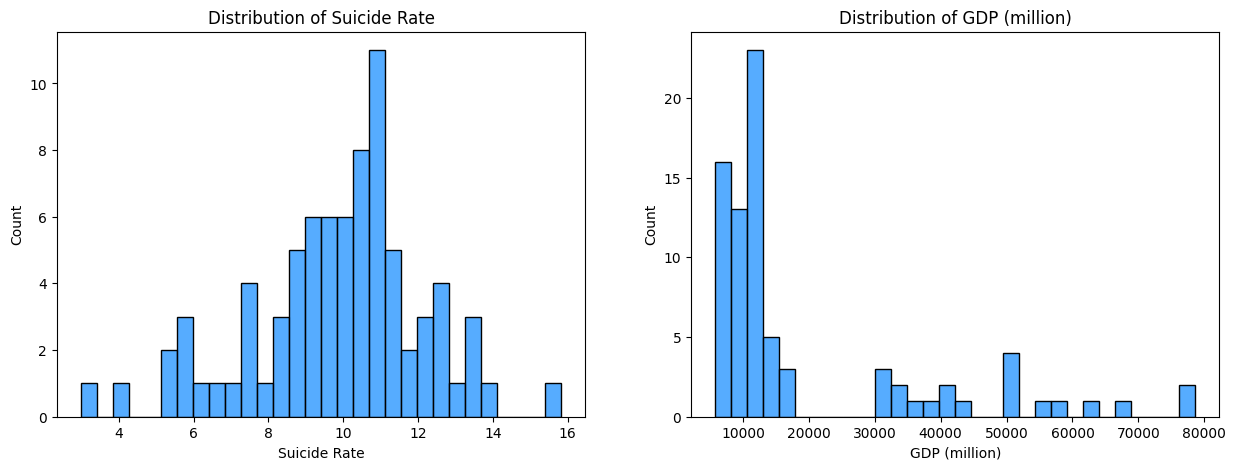

<Figure size 640x480 with 0 Axes>

(       Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
 count       80.0000       80.0000       80.0000       80.0000       80.0000   
 mean        39.5000       39.5000       39.5000       39.5000       39.5000   
 std         23.2379       23.2379       23.2379       23.2379       23.2379   
 min          0.0000        0.0000        0.0000        0.0000        0.0000   
 25%         19.7500       19.7500       19.7500       19.7500       19.7500   
 50%         39.5000       39.5000       39.5000       39.5000       39.5000   
 75%         59.2500       59.2500       59.2500       59.2500       59.2500   
 max         79.0000       79.0000       79.0000       79.0000       79.0000   
 
        Unnamed: 0         Year  Suicide Rate  GDP (million)  \
 count     80.0000    80.000000     80.000000      80.000000   
 mean      39.5000  2015.500000      9.891000   19822.875000   
 std       23.2379     2.890403      2.317063   18367.045775   
 min        0.0000  20

In [5]:

# Basic statistical overview
stats_overview = data_filled.describe()

# Checking for missing values post-filling
missing_values = data_filled.isnull().sum()

# Plotting distributions of numerical variables
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Histogram for Suicide Rate
sns.histplot(data_filled['Suicide Rate'], bins=30, ax=axes[0], color='dodgerblue')
axes[0].set_title('Distribution of Suicide Rate')

# Histogram for GDP (million)
sns.histplot(data_filled['GDP (million)'], bins=30, ax=axes[1], color='dodgerblue')
axes[1].set_title('Distribution of GDP (million)')
plt.show()

# Histogram for Depression Rate in %
sns.histplot(data_filled['Depression Rate in %'], bins=30, ax=axes[1], color='dodgerblue')
axes[1].set_title('Distribution of Depression Rate in %')

plt.tight_layout()
plt.show()

stats_overview, missing_values


In [6]:
gdp_list = data_filled['GDP (million)'].tolist()
print(gdp_list)

[30613.0, 5879.0, 6396.0, 8677.0, 9660.0, 50512.0, 12374.0, 11374.0, 31606.0, 5857.0, 6639.0, 8995.0, 10115.0, 51039.0, 12866.0, 11766.0, 31570.0, 5769.0, 6685.0, 8941.0, 10175.0, 50672.0, 11622.0, 11721.0, 32934.0, 5981.0, 6949.0, 9344.0, 10660.0, 51217.0, 11455.0, 11721.0, 33783.0, 6025.0, 7106.0, 9734.0, 10917.0, 55817.0, 12656.0, 11721.0, 36215.0, 6294.0, 7422.0, 10125.0, 12374.0, 59176.0, 13338.0, 11721.0, 38950.0, 6931.0, 7928.0, 10839.0, 13253.0, 63790.0, 14386.0, 11721.0, 41079.0, 7693.0, 8433.0, 11676.0, 13277.0, 68885.0, 15573.0, 11721.0, 42510.0, 7743.0, 8960.0, 12401.0, 13405.0, 77886.0, 17037.0, 11721.0, 41908.0, 8235.0, 9011.0, 12164.0, 12498.0, 78645.0, 17642.0, 11721.0]


In [7]:
gdp_list = data_filled['Year'].tolist()
print(gdp_list)

[2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020]


In [8]:
data_filled['Region'].unique()

array(['Severna i yugoiztochna Bulgaria', 'Severozapaden',
       'Severen tsentralen', 'Severoiztochen', 'Yugoiztochen',
       'Yugozapadna i yuzhna tsentralna Bulgaria', 'Yugozapaden',
       'Yuzhen tsentralen'], dtype=object)

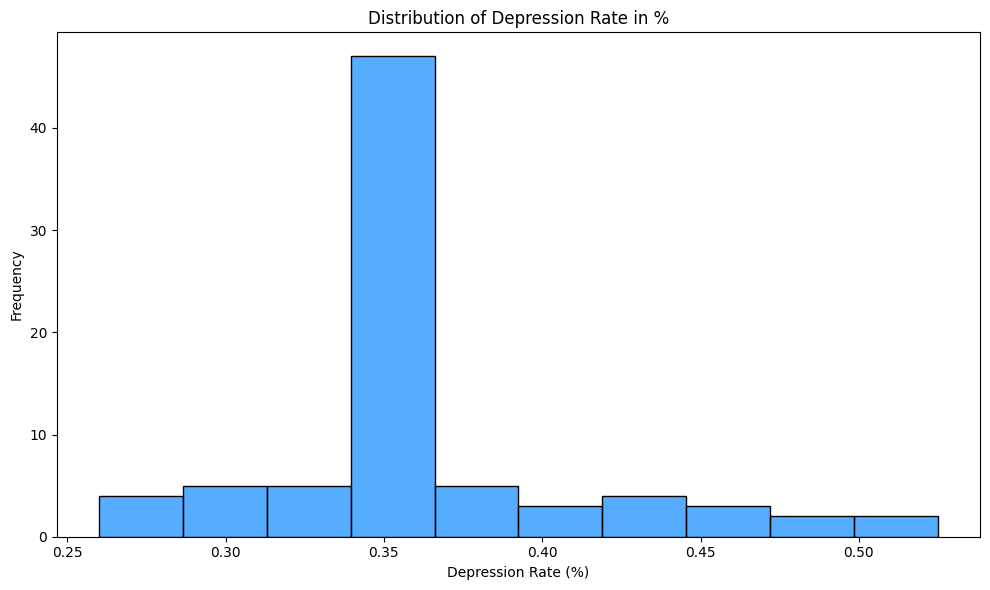

In [9]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Creating the histogram for Depression Rate in %
sns.histplot(data_filled['Depression Rate in %'], bins=10, color='dodgerblue')
plt.title('Distribution of Depression Rate in %')
plt.xlabel('Depression Rate (%)')
plt.ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()


In [10]:
# Preparing the data for panel data analysis
panel_data = data_filled.set_index(['Region', 'Year'])

# Defining the dependent and independent variables
independent = panel_data['Suicide Rate']
dependent = panel_data[['GDP (million)']]
independent = sm.add_constant(independent) # adding a constant

# Fixed Effects Model
fe_model = PanelOLS(dependent, independent, entity_effects=True)
fe_results = fe_model.fit()

# Random Effects Model
re_model = RandomEffects(dependent, independent)
re_results = re_model.fit()

# Displaying the results of both models
fe_results.summary, re_results.summary

(<class 'linearmodels.compat.statsmodels.Summary'>
 """
                           PanelOLS Estimation Summary                           
 Dep. Variable:          GDP (million)   R-squared:                        0.1816
 Estimator:                   PanelOLS   R-squared (Between):              0.0649
 No. Observations:                  80   R-squared (Within):               0.1816
 Date:                Sat, Mar 30 2024   R-squared (Overall):              0.0711
 Time:                        15:39:23   Log-likelihood                   -772.56
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      15.758
 Entities:                           8   P-value                           0.0002
 Avg Obs:                      10.0000   Distribution:                    F(1,71)
 Min Obs:                      10.0000                                           
 Max Obs:                      10.0000   F

In [11]:
# For Fixed Effects Model
fe_effect_size = fe_results.params['Suicide Rate']
fe_conf_int = fe_results.conf_int().loc['Suicide Rate']

# For Random Effects Model
re_effect_size = re_results.params['Suicide Rate']
re_conf_int = re_results.conf_int().loc['Suicide Rate']

print("Fixed Effects Model:")
print("Effect Size:", fe_effect_size)
print("95% Confidence Interval:", fe_conf_int)

print("\nRandom Effects Model:")
print("Effect Size:", re_effect_size)
print("95% Confidence Interval:", re_conf_int)


Fixed Effects Model:
Effect Size: -1206.9973490501416
95% Confidence Interval: lower   -1813.277198
upper    -600.717500
Name: Suicide Rate, dtype: float64

Random Effects Model:
Effect Size: -1219.953106939133
95% Confidence Interval: lower   -1820.708211
upper    -619.198003
Name: Suicide Rate, dtype: float64


In [12]:
panel_data = data_filled.set_index(['Region', 'Year'])

# Defining the dependent and independent variables
dependent = panel_data['GDP (million)']
independent = panel_data[['Suicide Rate', 'Depression Rate in %']] # Now includes Depression Rate
independent = sm.add_constant(independent) # adding a constant

# Fixed Effects Model
fe_model = PanelOLS(dependent, independent, entity_effects=True)
fe_results2 = fe_model.fit()

# Random Effects Model
re_model = RandomEffects(dependent, independent)
re_results2 = re_model.fit()

# Displaying the results of both models
print(fe_results2.summary)
print(re_results2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          GDP (million)   R-squared:                        0.1874
Estimator:                   PanelOLS   R-squared (Between):              0.0615
No. Observations:                  80   R-squared (Within):               0.1874
Date:                Sat, Mar 30 2024   R-squared (Overall):              0.0681
Time:                        15:39:23   Log-likelihood                   -772.28
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.0694
Entities:                           8   P-value                           0.0007
Avg Obs:                      10.0000   Distribution:                    F(2,70)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             8.0694
                            

In [13]:
# For Fixed Effects Model
fe_effect_size2 = fe_results2.params['Suicide Rate']
fe_conf_int2 = fe_results2.conf_int().loc['Suicide Rate']

# For Random Effects Model
re_effect_size2 = re_results2.params['Suicide Rate']
re_conf_int2 = re_results2.conf_int().loc['Suicide Rate']

print("Fixed Effects Model:")
print("Effect Size:", fe_effect_size2)
print("95% Confidence Interval:", fe_conf_int2)

print("\nRandom Effects Model:")
print("Effect Size:", re_effect_size2)
print("95% Confidence Interval:", re_conf_int2)


Fixed Effects Model:
Effect Size: -1122.321087372405
95% Confidence Interval: lower   -1776.681530
upper    -467.960645
Name: Suicide Rate, dtype: float64

Random Effects Model:
Effect Size: -1136.9798239378315
95% Confidence Interval: lower   -1780.016096
upper    -493.943552
Name: Suicide Rate, dtype: float64


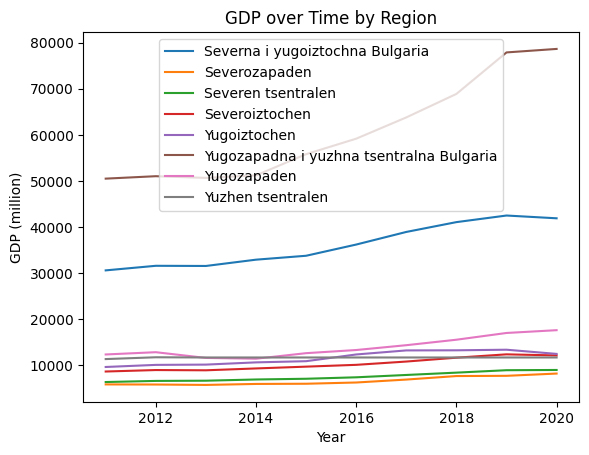

In [14]:
import matplotlib.pyplot as plt

# Grouping the data by region and plotting
for region in data_filled['Region'].unique():
    region_data = data_filled[data_filled['Region'] == region]
    plt.plot(region_data['Year'], region_data['GDP (million)'], label=region)

plt.xlabel('Year')
plt.ylabel('GDP (million)')
plt.title('GDP over Time by Region')
plt.legend()
plt.show()


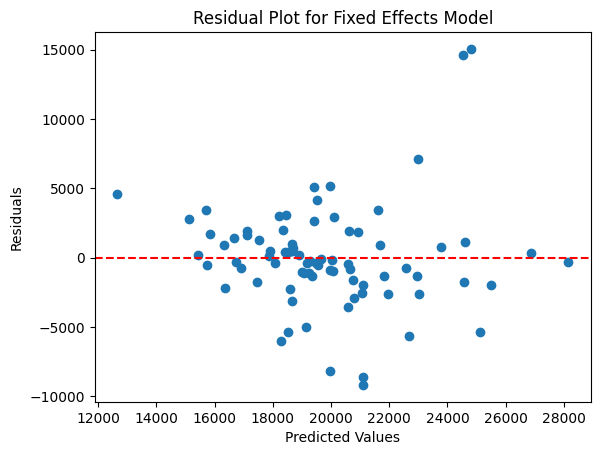

In [15]:
# Extracting residuals from the Fixed Effects model
fe_residuals = fe_results.resids

# Plotting the residuals
plt.scatter(fe_results.predict(), fe_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Fixed Effects Model')
plt.show()


### Feature Engineering

In [16]:
data_filled.head(10)

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,0,0,0,0,0,Severna i yugoiztochna Bulgaria,2011,10.96,30613.0,0.3635
1,1,1,1,1,1,1,Severozapaden,2011,10.56,5879.0,0.3500
2,2,2,2,2,2,2,Severen tsentralen,2011,9.27,6396.0,0.3635
3,3,3,3,3,3,3,Severoiztochen,2011,10.34,8677.0,0.3850
4,4,4,4,4,4,4,Yugoiztochen,2011,13.28,9660.0,0.4550
5,5,5,5,5,5,5,Yugozapadna i yuzhna tsentralna Bulgaria,2011,9.78,50512.0,0.3635
6,6,6,6,6,6,6,Yugozapaden,2011,8.36,12374.0,0.5250
7,7,7,7,7,7,7,Yuzhen tsentralen,2011,11.80,11374.0,0.3635
8,8,8,8,8,8,8,Severna i yugoiztochna Bulgaria,2012,12.76,31606.0,0.3635
9,9,9,9,9,9,9,Severozapaden,2012,11.51,5857.0,0.3400


In [17]:
# Encoding the Regions from categorical to Numerical variables
if data_filled['Region'].dtype == 'object':
    le = LabelEncoder()
    data_filled['Region'] = le.fit_transform(data_filled['Region'])


In [18]:
data_filled

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,0,0,0,0,0,1,2011,10.96,30613.0,0.3635
1,1,1,1,1,1,1,3,2011,10.56,5879.0,0.3500
2,2,2,2,2,2,2,0,2011,9.27,6396.0,0.3635
3,3,3,3,3,3,3,2,2011,10.34,8677.0,0.3850
4,4,4,4,4,4,4,4,2011,13.28,9660.0,0.4550
...,...,...,...,...,...,...,...,...,...,...,...
75,75,75,75,75,75,75,2,2020,9.24,12164.0,0.2860
76,76,76,76,76,76,76,4,2020,10.29,12498.0,0.3380
77,77,77,77,77,77,77,6,2020,5.75,78645.0,0.3635
78,78,78,78,78,78,78,5,2020,2.99,17642.0,0.3900


Normalizing input features is an important step in preparing your data for use in a machine learning model, including neural networks. Normalization typically involves scaling the data so that the range of the variable is consistent across all features. This process can help improve the performance and training stability of the model. A common method for normalization is Min-Max scaling, which scales the data to a fixed range, usually 0 to 1.

Here's how you can normalize your features - depression rates, suicide rates, and GDP:

1. **Min-Max Normalization**: This scales the data to a range of [0, 1]. The formula is:

   $X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

   Where:
   - $X$ is the original value.
   - $X_{\text{min}}$ is the minimum value in the feature.
   - $X_{\text{max}}$ is the maximum value in the feature.
   - $X_{\text{norm}}$ is the normalized value.

2. **Standardization (Z-Score Normalization)**: Another common method is Z-score normalization, where the features are scaled based on their mean (μ) and standard deviation (σ), resulting in a distribution with a mean of 0 and a standard deviation of 1. The formula is:

   $X_{\text{norm}} = \frac{X - \mu}{\sigma}$

   However, for neural networks, Min-Max scaling is often preferred as it keeps the values in a bounded range, which is particularly useful for models using activation functions like sigmoid or tanh.


In [19]:
# Selecting the columns to be normalized
features_to_normalize = ['Suicide Rate', 'GDP (million)']

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
data_filled[features_to_normalize] = scaler.fit_transform(data_filled[features_to_normalize])


In [20]:
data_filled.to_csv('ModelFeeder.csv')
data_filled

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,0,0,0,0,0,1,2011,0.620717,0.340908,0.3635
1,1,1,1,1,1,1,3,2011,0.589564,0.001509,0.3500
2,2,2,2,2,2,2,0,2011,0.489097,0.008604,0.3635
3,3,3,3,3,3,3,2,2011,0.572430,0.039903,0.3850
4,4,4,4,4,4,4,4,2011,0.801402,0.053392,0.4550
...,...,...,...,...,...,...,...,...,...,...,...
75,75,75,75,75,75,75,2,2020,0.486760,0.087752,0.2860
76,76,76,76,76,76,76,4,2020,0.568536,0.092335,0.3380
77,77,77,77,77,77,77,6,2020,0.214953,1.000000,0.3635
78,78,78,78,78,78,78,5,2020,0.000000,0.162921,0.3900


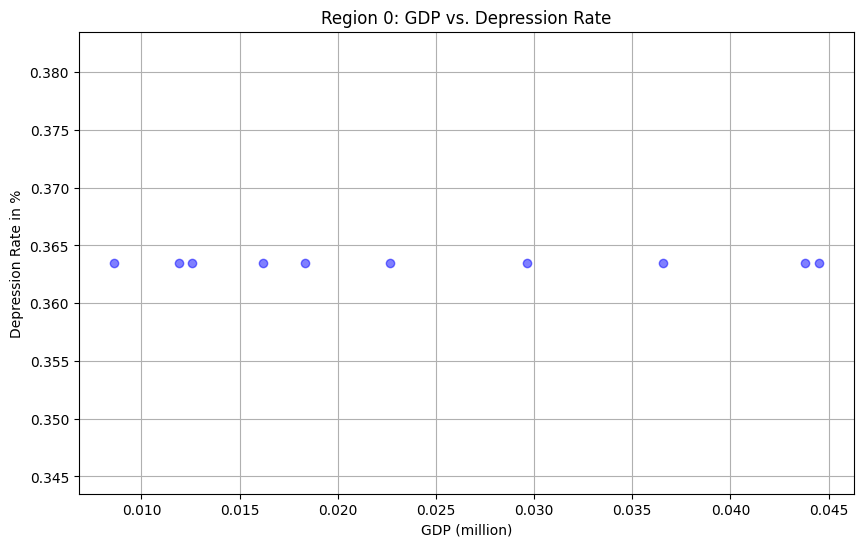

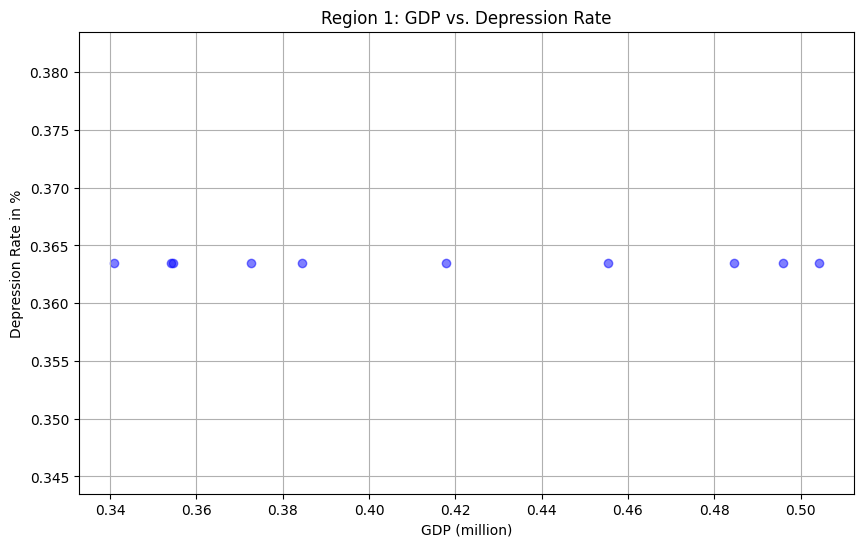

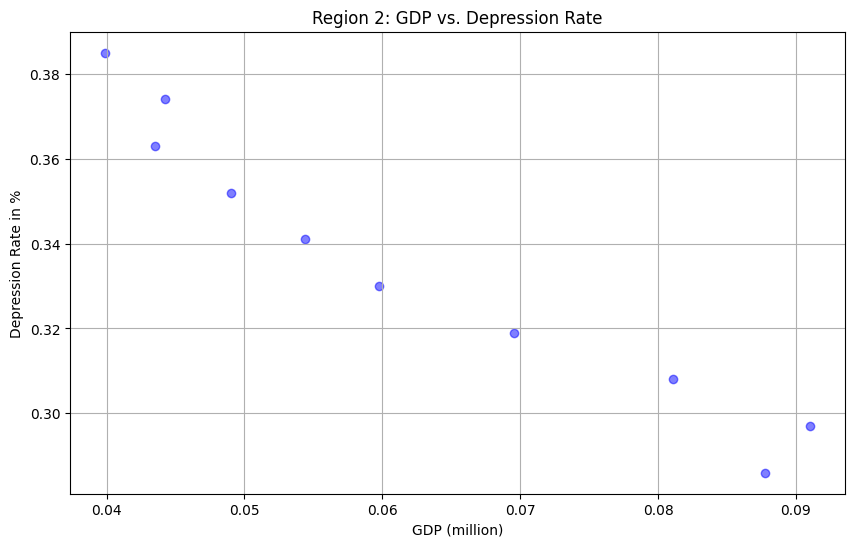

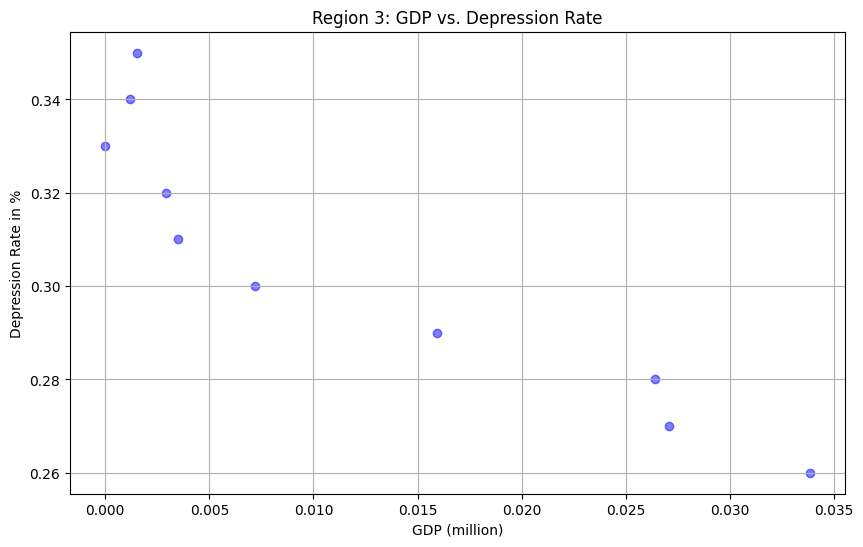

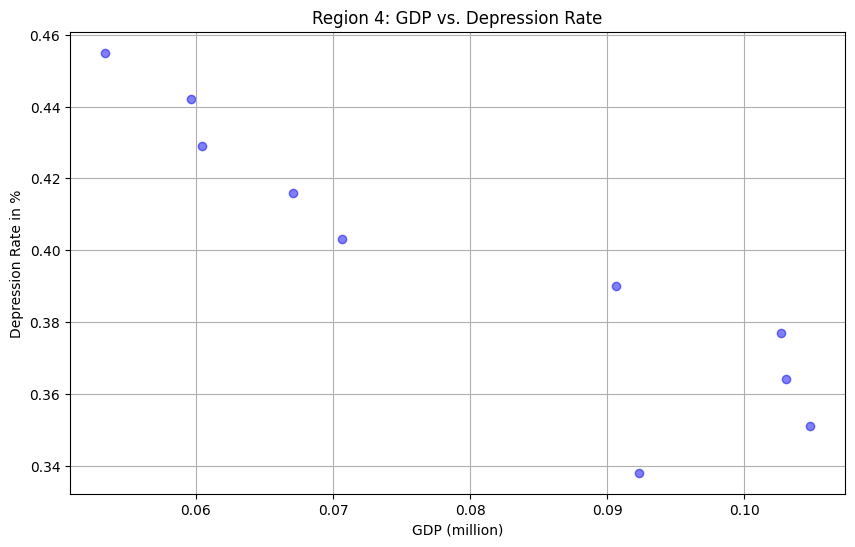

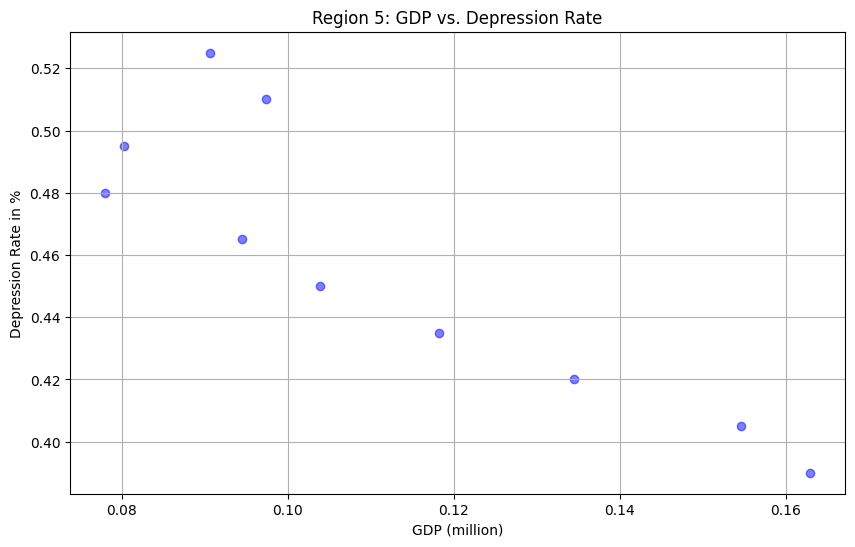

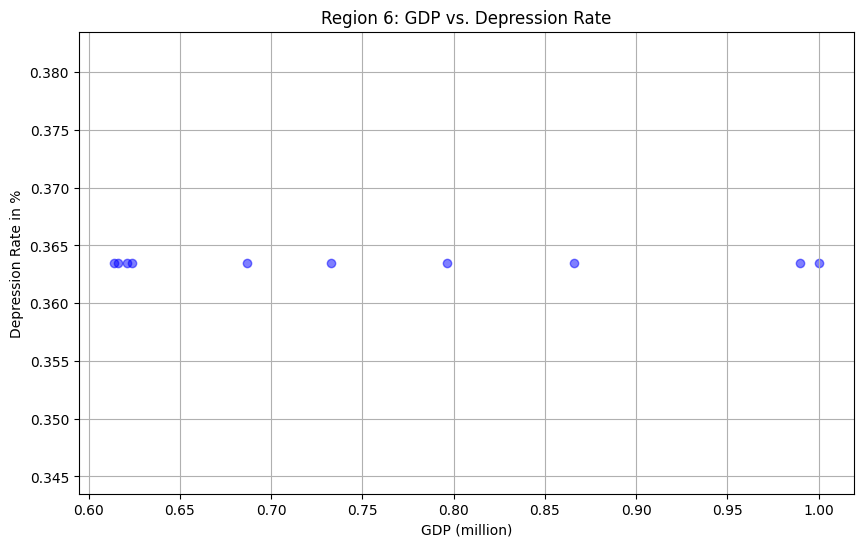

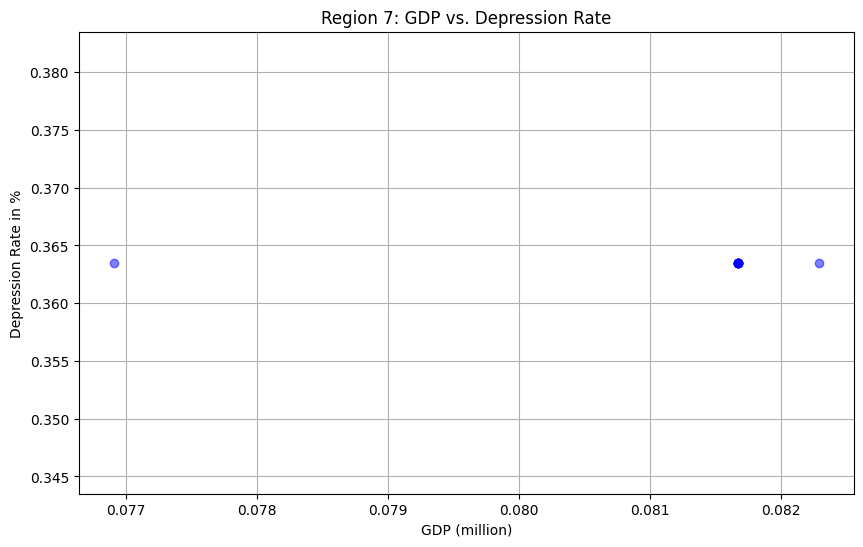

In [21]:

unique_regions = data_filled['Region'].unique()

for region in sorted(unique_regions):
    # Filter data for the current region
    region_data = data_filled[data_filled['Region'] == region]
    
    # Create a scatter plot for the current region
    plt.figure(figsize=(10, 6))
    plt.scatter(region_data['GDP (million)'], region_data['Depression Rate in %'], color='blue', alpha=0.5)
    plt.title(f'Region {region}: GDP vs. Depression Rate')
    plt.xlabel('GDP (million)')
    plt.ylabel('Depression Rate in %')
    plt.grid(True)
    plt.show()


In [22]:
data_filled.dtypes

Unnamed: 0.5              int64
Unnamed: 0.4              int64
Unnamed: 0.3              int64
Unnamed: 0.2              int64
Unnamed: 0.1              int64
Unnamed: 0                int64
Region                    int64
Year                      int64
Suicide Rate            float64
GDP (million)           float64
Depression Rate in %    float64
dtype: object

In [23]:
missing_values = data_filled.isnull().sum()
print(missing_values)


Unnamed: 0.5            0
Unnamed: 0.4            0
Unnamed: 0.3            0
Unnamed: 0.2            0
Unnamed: 0.1            0
Unnamed: 0              0
Region                  0
Year                    0
Suicide Rate            0
GDP (million)           0
Depression Rate in %    0
dtype: int64


In [175]:
from sklearn.model_selection import train_test_split

# Selecting features and target for OLSCNNModel
features = data_filled[['Depression Rate in %', 'Suicide Rate']]
target = data_filled['GDP (million)']


In [176]:
sorted_data = data_filled.sort_values(by=['Region', 'Year'])
sorted_data

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
2,2,2,2,2,2,2,0,2011,0.489097,0.008604,0.3635
10,10,10,10,10,10,10,0,2012,1.000000,0.011938,0.3635
18,18,18,18,18,18,18,0,2013,0.762461,0.012569,0.3635
26,26,26,26,26,26,26,0,2014,0.795171,0.016192,0.3635
34,34,34,34,34,34,34,0,2015,0.651090,0.018346,0.3635
...,...,...,...,...,...,...,...,...,...,...,...
47,47,47,47,47,47,47,7,2016,0.558411,0.081673,0.3635
55,55,55,55,55,55,55,7,2017,0.612150,0.081673,0.3635
63,63,63,63,63,63,63,7,2018,0.478193,0.081673,0.3635
71,71,71,71,71,71,71,7,2019,0.454050,0.081673,0.3635


In [177]:
sorted_data = sorted_data[['Region', 'Year', 'Suicide Rate', 'GDP (million)', 'Depression Rate in %']]
sorted_data

,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
2,0,2011,0.489097,0.008604,0.3635
10,0,2012,1.000000,0.011938,0.3635
18,0,2013,0.762461,0.012569,0.3635
26,0,2014,0.795171,0.016192,0.3635
34,0,2015,0.651090,0.018346,0.3635
...,...,...,...,...,...
47,7,2016,0.558411,0.081673,0.3635
55,7,2017,0.612150,0.081673,0.3635
63,7,2018,0.478193,0.081673,0.3635
71,7,2019,0.454050,0.081673,0.3635


In [128]:
def create_sequences(data, seq_len):
    sequences = []
    target = []
    for i in range(len(data) - seq_len):
        seq = data[i:i + seq_len]
        label = data.iloc[i + seq_len]['GDP (million)']  # Next year's GDP as the target
        sequences.append(seq[['Depression Rate in %', 'Suicide Rate']].values)
        target.append(label)
    return np.array(sequences), np.array(target)

# Create sequences for each region
seq_len = 5
region_sequences = []
region_targets = []
for region in sorted_data['Region'].unique():
    region_data = sorted_data[sorted_data['Region'] == region]
    sequences, targets = create_sequences(region_data, seq_len)
    region_sequences.append(sequences)
    region_targets.append(targets)

# Concatenate all region sequences and targets
final_sequences = np.concatenate(region_sequences)
final_targets = np.concatenate(region_targets)


In [147]:
# Checking the dimentions of final_sequences
final_sequences.shape

(40, 5, 2)

In [148]:
final_targets.shape

(40,)

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_sequences, final_targets, test_size=0.2, random_state=42, shuffle=False)


In [179]:
print(len(X_train)) == print(len(y_train))
print(len(X_test)) == print(len(y_test))

32
32
8
8


True

In [180]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [181]:
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model

In [182]:
# This function assumes that 'cnn_features' are the output of the last CNN layer before flattening
def train_ols_model(cnn_features, targets):
    ols_model = LinearRegression()
    ols_model.fit(cnn_features, targets)
    return ols_model

def create_lstm_cnn_model(input_shape):
    model = Sequential()
    
    # LSTM layer with dropout
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Reshape output for CNN input
    model.add(Dense(64, activation='relu'))
    model.add(Reshape((64, 1)))
    
    # CNN layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # Dense layers for prediction with dropout
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model


In [152]:
# Create and train the LSTM-CNN model
input_shape = (seq_len, 2)
lstm_cnn_model = create_lstm_cnn_model(input_shape)

# Train the LSTM-CNN model
lstm_cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Extract features for the OLS model from the second to last Dense layer
# We use '-2' index for the second to last layer because the last layer is the output layer
feature_layer = lstm_cnn_model.layers[-2].output
feature_extractor_model = Model(inputs=lstm_cnn_model.input, outputs=feature_layer)

# Extract features from both training and test sets
cnn_features_train = feature_extractor_model.predict(X_train)
cnn_features_test = feature_extractor_model.predict(X_test)

# Define and train the OLS model on extracted features
ols_model = LinearRegression()
ols_model.fit(cnn_features_train, y_train)

# Make predictions with both models on the test set
lstm_cnn_predictions = lstm_cnn_model.predict(X_test)
ols_predictions = ols_model.predict(cnn_features_test)

# Calculate RMSE for both models
lstm_cnn_rmse = sqrt(mean_squared_error(y_test, lstm_cnn_predictions))
ols_rmse = sqrt(mean_squared_error(y_test, ols_predictions))

print("LSTM-CNN RMSE:", lstm_cnn_rmse)
print("OLS RMSE:", ols_rmse)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.0455 - val_loss: 0.2924
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0405 - val_loss: 0.2767
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0366 - val_loss: 0.2568
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0309 - val_loss: 0.2324
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0266 - val_loss: 0.2035
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0254 - val_loss: 0.1753
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0275 - val_loss: 0.1603
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0351 - val_loss: 0.1652
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0279 - val_loss: 0.1750
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0295 - val_loss: 0.1876
Epoch 11/100
1/1 [===

1/1 [==============================] - 0s 28ms/step


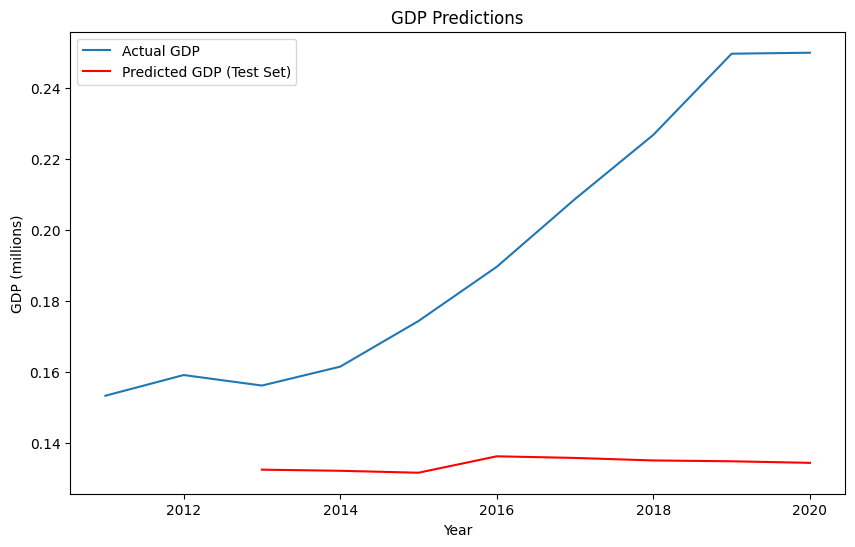

In [183]:

# Get the last sequence from X_test to start the prediction
current_sequence = X_test[-1].reshape((1, seq_len, 2))

# Store the predicted GDP from the test set
predicted_gdp_test = lstm_cnn_model.predict(X_test)

# Future predictions
future_predictions = []

# Predict 3 years into the future
for _ in range(3):
    # Get the next year GDP prediction from the model
    next_year_gdp = lstm_cnn_model.predict(current_sequence)[0][0]
    
    # Add this prediction to the future_predictions
    future_predictions.append(next_year_gdp)
    
    # Update the current_sequence with the predicted GDP
    # Reshape the scalar prediction to have the same number of dimensions as current_sequence
    new_prediction = np.array([[next_year_gdp]]).reshape(1, 1, 1)  # Shape is now (1, 1, 1)
    
    # Construct a new time step by replicating the last features across the sequence length
    # We assume that the features other than GDP are constant (or carry forward the last known values)
    new_time_step = np.concatenate([new_prediction] * seq_len, axis=1)  # Shape is now (1, seq_len, 1)
    
    # Update the current sequence by rolling it to remove the oldest time step and appending the new time step
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[:, -1:, :] = new_time_step[:, -1:, :]

# Assuming you have variables predicted_gdp_test and future_predictions as before
# Extract years and actual GDP values from sorted_data
years = sorted_data['Year'].unique()  # This assumes 'Year' is sorted
actual_gdp = sorted_data.groupby('Year')['GDP (million)'].mean()  # Example aggregation

# Prepare the data for future predictions
last_known_year = years[-1]
future_years = np.array([last_known_year + i for i in range(1, 4)])  # Next 3 years
all_years = np.concatenate([years, future_years])  # Combine existing years with future years

# Here, we adjust 'test_years' based on how 'predicted_gdp_test' aligns with your actual data
test_years = years[-len(predicted_gdp_test):]

plt.figure(figsize=(10, 6))

# Plot actual GDP data
plt.plot(years, actual_gdp, label='Actual GDP')

# Plot predicted GDP for the test set
plt.plot(test_years, predicted_gdp_test, 'r', label='Predicted GDP (Test Set)')

# Plot future GDP predictions
#plt.plot(future_years, future_predictions, 'g-.', label='Future Predicted GDP')

plt.xlabel('Year')
plt.ylabel('GDP (millions)')
plt.title('GDP Predictions')
plt.legend()
plt.show()

plt.show()


In [184]:
# Create sequences for each region
seq_len = 5
region_models = {}
region_predictions = {}

# Assuming you have 7 regions, numbered from 0 to 6
for region in range(7):
    # Filter the sorted data for the current region
    region_data = sorted_data[sorted_data['Region'] == region]
    
    # Create sequences specifically for the current region
    sequences, targets = create_sequences(region_data, seq_len)
    
    # Split the data into training and testing sets for the current region
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, targets, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Initialize the model
    input_shape = (seq_len, 2)  # Adjust 2 to your number of features
    model = create_lstm_cnn_model(input_shape)
    
    # Train the model on the region's data
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
    
    # Store the trained model
    region_models[region] = model
    
    # Make predictions on the test set
    predicted_gdp_test = model.predict(X_test)
    
    # Store the predicted and actual GDP for the test set
    region_predictions[region] = {
        'predicted_gdp_test': predicted_gdp_test.flatten(),
        'actual_gdp_test': y_test,
        'X_test': X_test
    }



Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 9.5982e-04 - val_loss: 9.7795e-04
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 3.2332e-04 - val_loss: 2.4418e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 6.2751e-05 - val_loss: 3.7032e-06
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 2.2433e-04 - val_loss: 1.0994e-05
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 2.5403e-04 - val_loss: 1.1922e-04
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 4.7344e-05 - val_loss: 3.2308e-04
Epoch 7/10
1/1 [==============================] - 0s 32ms/step - loss: 5.6572e-05 - val_loss: 4.8093e-04
Epoch 8/10
1/1 [==============================] - 0s 32ms/step - loss: 1.0142e-04 - val_loss: 5.1035e-04
Epoch 9/10
1/1 [==============================] - 0s 32ms/step - loss: 3.2596e-05 - val_loss: 4.5744e-04
Epoch 10/10
1/1 [==============================] - 1s 830

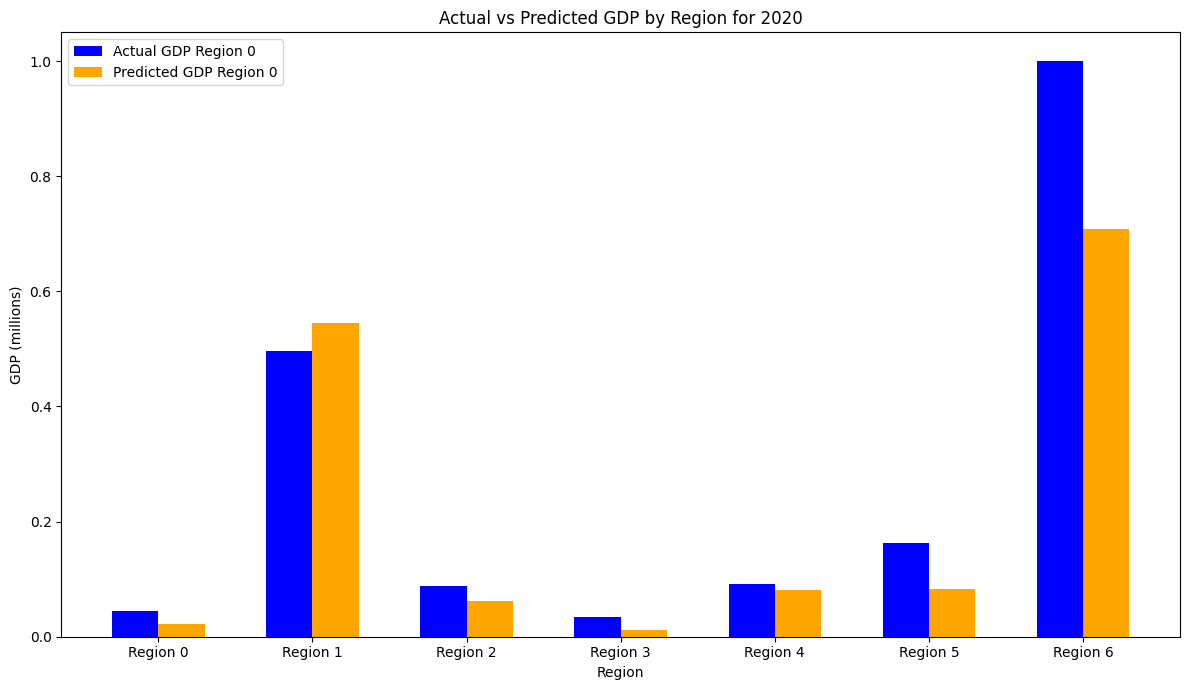

In [159]:
# Set the positions of the bars on the x-axis
indices = np.arange(len(region_predictions))

# Width of a bar 
width = 0.3       

# Start a new figure
plt.figure(figsize=(12, 7))

# Plotting
for i, region in enumerate(region_predictions):
    actual_gdp = region_predictions[region]['actual_gdp_test']
    predicted_gdp = region_predictions[region]['predicted_gdp_test']
    
    # Plot the actual GDP bar
    plt.bar(indices[i] - width/2, actual_gdp, width, label=f'Actual GDP Region {region}' if i == 0 else "", color='blue')
    
    # Plot the predicted GDP bar
    plt.bar(indices[i] + width/2, predicted_gdp, width, label=f'Predicted GDP Region {region}' if i == 0 else "", color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Region')
plt.ylabel('GDP (millions)')
plt.title('Actual vs Predicted GDP by Region for 2020')

# X-axis ticks
plt.xticks(indices, [f'Region {i}' for i in range(len(region_predictions))])

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# mse for 

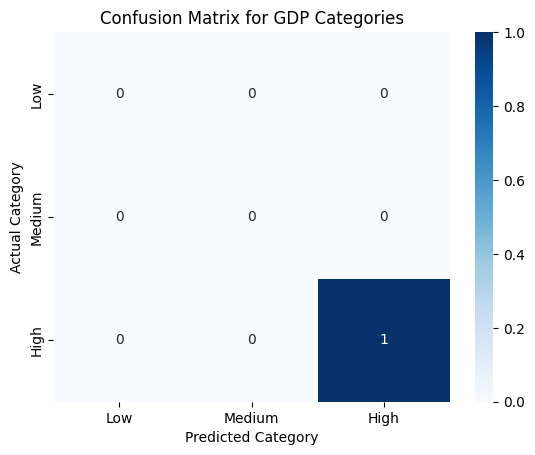

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define thresholds for categorization
low_threshold = 0.02
high_threshold = 0.16

# Function to categorize GDP values
def categorize_gdp(gdp_value):
    if gdp_value < low_threshold:
        return 'Low'
    elif gdp_value < high_threshold:
        return 'Medium'
    else:
        return 'High'

# Categorize actual and predicted GDP values
actual_categories = [categorize_gdp(val) for val in actual_gdp]
predicted_categories = [categorize_gdp(val) for val in predicted_gdp]

# Calculate the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories, labels=['Low', 'Medium', 'High'])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for GDP Categories')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Instantiate the model
input_size = 2  # Number of features (Depression Rate and Suicide Rate)
hidden_size = 50  # Number of features in the hidden state
num_layers = 1  # Number of stacked LSTM layers
output_size = 1  # Output size (GDP)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Number of epochs
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))  # Make sure targets are correctly shaped
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.25018763542175293
Epoch 2/100, Loss: 0.23886072635650635
Epoch 3/100, Loss: 0.22816964983940125
Epoch 4/100, Loss: 0.21807900071144104
Epoch 5/100, Loss: 0.20855112373828888
Epoch 6/100, Loss: 0.1995449960231781
Epoch 7/100, Loss: 0.19101861119270325
Epoch 8/100, Loss: 0.18293146789073944
Epoch 9/100, Loss: 0.17524686455726624
Epoch 10/100, Loss: 0.16793286800384521
Epoch 11/100, Loss: 0.16096290946006775
Epoch 12/100, Loss: 0.15431582927703857
Epoch 13/100, Loss: 0.14797571301460266
Epoch 14/100, Loss: 0.14193174242973328
Epoch 15/100, Loss: 0.1361781507730484
Epoch 16/100, Loss: 0.13071414828300476
Epoch 17/100, Loss: 0.1255439817905426
Epoch 18/100, Loss: 0.12067702412605286
Epoch 19/100, Loss: 0.11612792313098907
Epoch 20/100, Loss: 0.11191640049219131
Epoch 21/100, Loss: 0.1080671176314354
Epoch 22/100, Loss: 0.10460901260375977
Epoch 23/100, Loss: 0.10157407820224762
Epoch 24/100, Loss: 0.09899531304836273
Epoch 25/100, Loss: 0.09690365195274353
Epoch 26/100,

In [ ]:
model.eval()  # Set the model to evaluation mode
test_losses = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_losses.append(loss.item())
average_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {average_loss}')


Test Loss: 0.047979649156332016


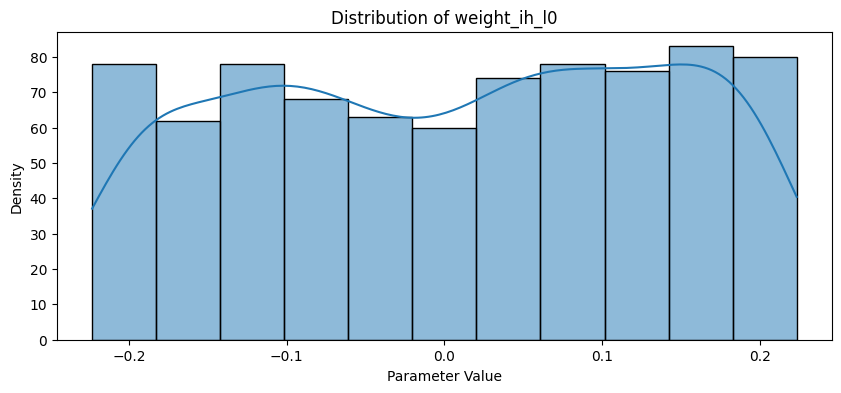

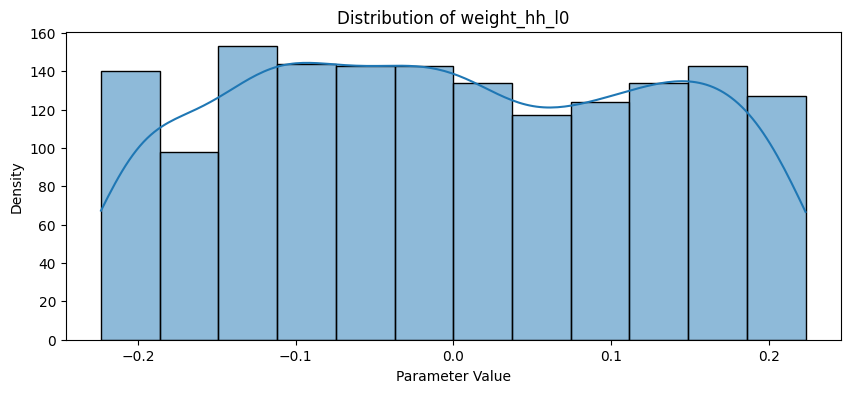

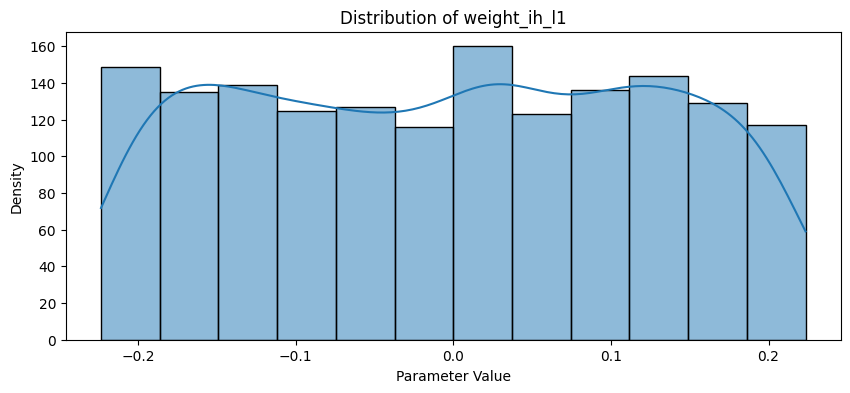

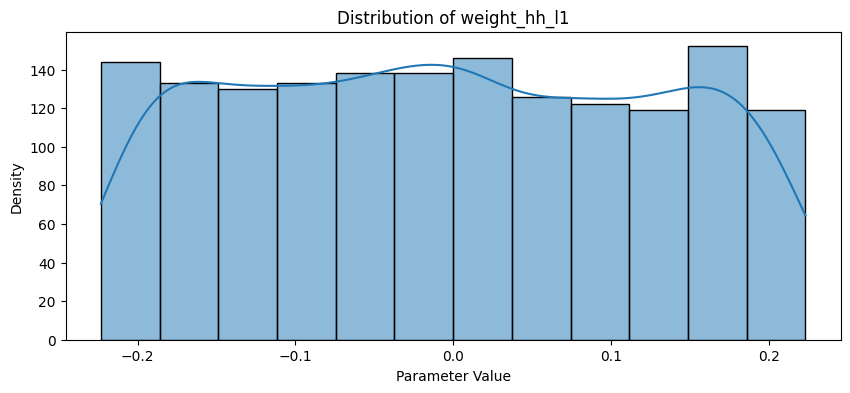

In [ ]:
model = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)

for name, param in model.named_parameters():
    if 'weight' in name:
        plt.figure(figsize=(10, 4))
        sns.histplot(param.data.numpy().flatten(), kde=True)
        plt.title(f'Distribution of {name}')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
        plt.show()

In [34]:
sorted_data

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
2,2,2,2,2,2,2,0,2011,0.489097,0.008604,0.3635
10,10,10,10,10,10,10,0,2012,1.000000,0.011938,0.3635
18,18,18,18,18,18,18,0,2013,0.762461,0.012569,0.3635
26,26,26,26,26,26,26,0,2014,0.795171,0.016192,0.3635
34,34,34,34,34,34,34,0,2015,0.651090,0.018346,0.3635
...,...,...,...,...,...,...,...,...,...,...,...
47,47,47,47,47,47,47,7,2016,0.558411,0.081673,0.3635
55,55,55,55,55,55,55,7,2017,0.612150,0.081673,0.3635
63,63,63,63,63,63,63,7,2018,0.478193,0.081673,0.3635
71,71,71,71,71,71,71,7,2019,0.454050,0.081673,0.3635


In [36]:
sorted_data = sorted_data[['Region', 'Year', 'Suicide Rate', 'GDP (million)', 'Depression Rate in %']]
sorted_data

,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
2,0,2011,0.489097,0.008604,0.3635
10,0,2012,1.000000,0.011938,0.3635
18,0,2013,0.762461,0.012569,0.3635
26,0,2014,0.795171,0.016192,0.3635
34,0,2015,0.651090,0.018346,0.3635
...,...,...,...,...,...
47,7,2016,0.558411,0.081673,0.3635
55,7,2017,0.612150,0.081673,0.3635
63,7,2018,0.478193,0.081673,0.3635
71,7,2019,0.454050,0.081673,0.3635


In [38]:
sorted_data['Region'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [39]:
sorted_data['Year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

(array([ 2.,  2.,  5.,  6., 14., 20., 18.,  8.,  4.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

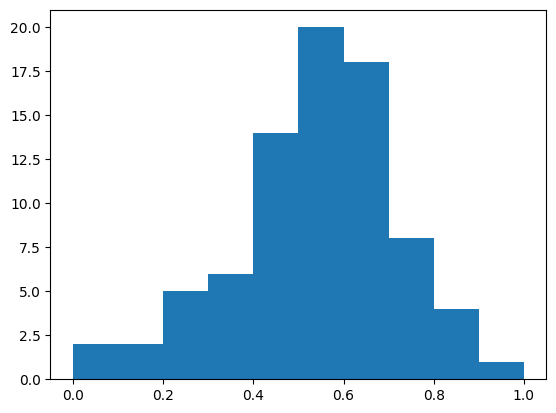

In [43]:
sorted_data['Suicide Rate'].unique()
plt.hist(sorted_data['Suicide Rate'], bins=10)

(array([52.,  8.,  0.,  5.,  4.,  1.,  5.,  2.,  1.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

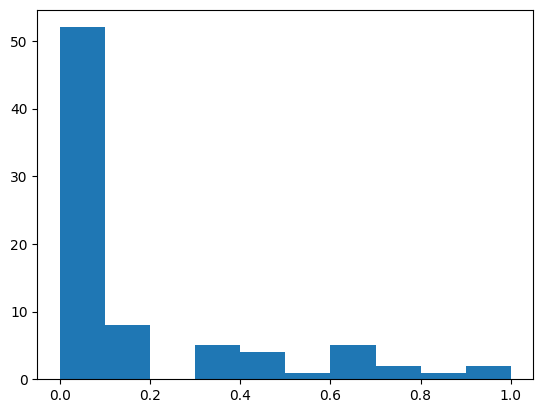

In [45]:
sorted_data['GDP (million)'].unique()
plt.hist(sorted_data['GDP (million)'], bins=10)

(array([ 4.,  5.,  5., 47.,  5.,  3.,  4.,  3.,  2.,  2.]),
 array([0.26  , 0.2865, 0.313 , 0.3395, 0.366 , 0.3925, 0.419 , 0.4455,
        0.472 , 0.4985, 0.525 ]),
 <BarContainer object of 10 artists>)

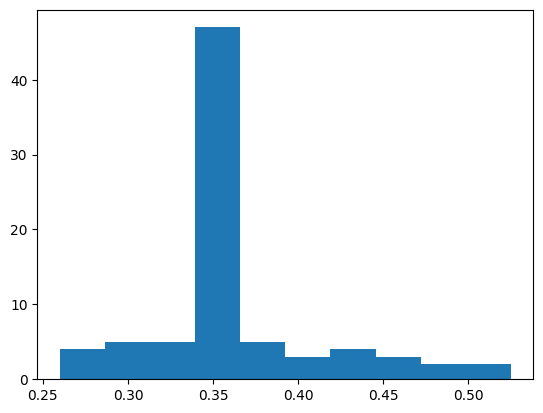

In [46]:
sorted_data['Depression Rate in %'].unique()
plt.hist(sorted_data['Depression Rate in %'], bins=10)

In [48]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [49]:
data_rest = sorted_data[['Region', 'Year', 'Suicide Rate', 'Depression Rate in %']].values
data_gdp = sorted_data['GDP (million)'].values

In [55]:
with pm.Model() as GDP_pmodel_on_all:
    # Priors
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0, sigma=10)
    beta_depression = pm.Normal('beta_depression', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome, assuming linear relationship
    mu = intercept + beta_gdp * data_gdp + beta_depression * data_rest[:, 3]
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=data_rest[:, 2])


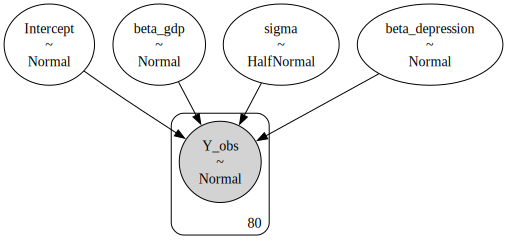

In [191]:
pm.model_to_graphviz(GDP_pmodel_on_all)

In [56]:
with GDP_pmodel_on_all:
    # Sample from the posterior
    trace_model_all = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_gdp, beta_depression, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        0.844  0.148   0.557    1.107      0.004    0.003    1712.0   
beta_gdp        -0.222  0.079  -0.370   -0.075      0.001    0.001    2845.0   
beta_depression -0.717  0.398  -1.470    0.016      0.010    0.007    1693.0   
sigma            0.173  0.014   0.147    0.199      0.000    0.000    2119.0   

                 ess_tail  r_hat  
Intercept          1473.0    1.0  
beta_gdp           2286.0    1.0  
beta_depression    1529.0    1.0  
sigma              2109.0    1.0  


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'beta_gdp'}>,
       <Axes: title={'center': 'beta_depression'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

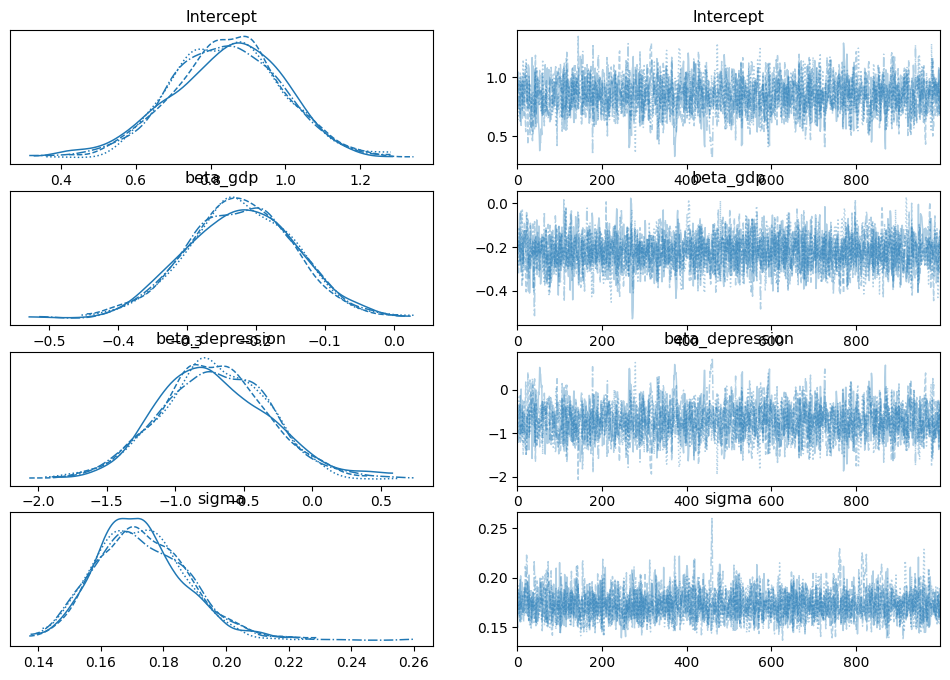

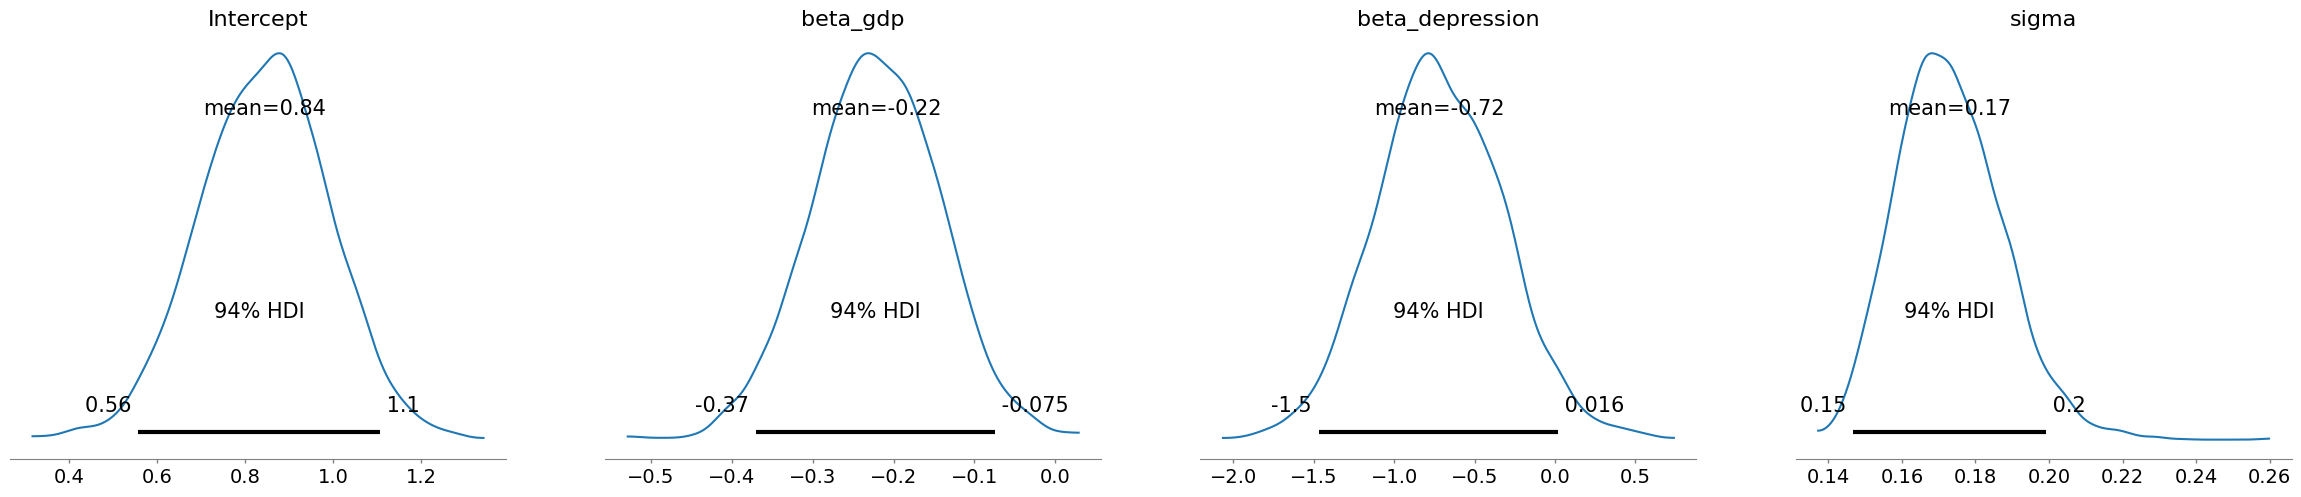

In [57]:
# Plotting the posterior distributions of the coefficients
az.plot_trace(trace_model_all)

# Summary statistics for the posterior distributions
print(az.summary(trace_model_all))

# Checking for model convergence and fit
az.plot_posterior(trace_model_all)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


array([[<Axes: ylabel='beta_gdp'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_depression'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='sigma'>,
        <Axes: xlabel='beta_gdp'>, <Axes: xlabel='beta_depression'>]],
      dtype=object)

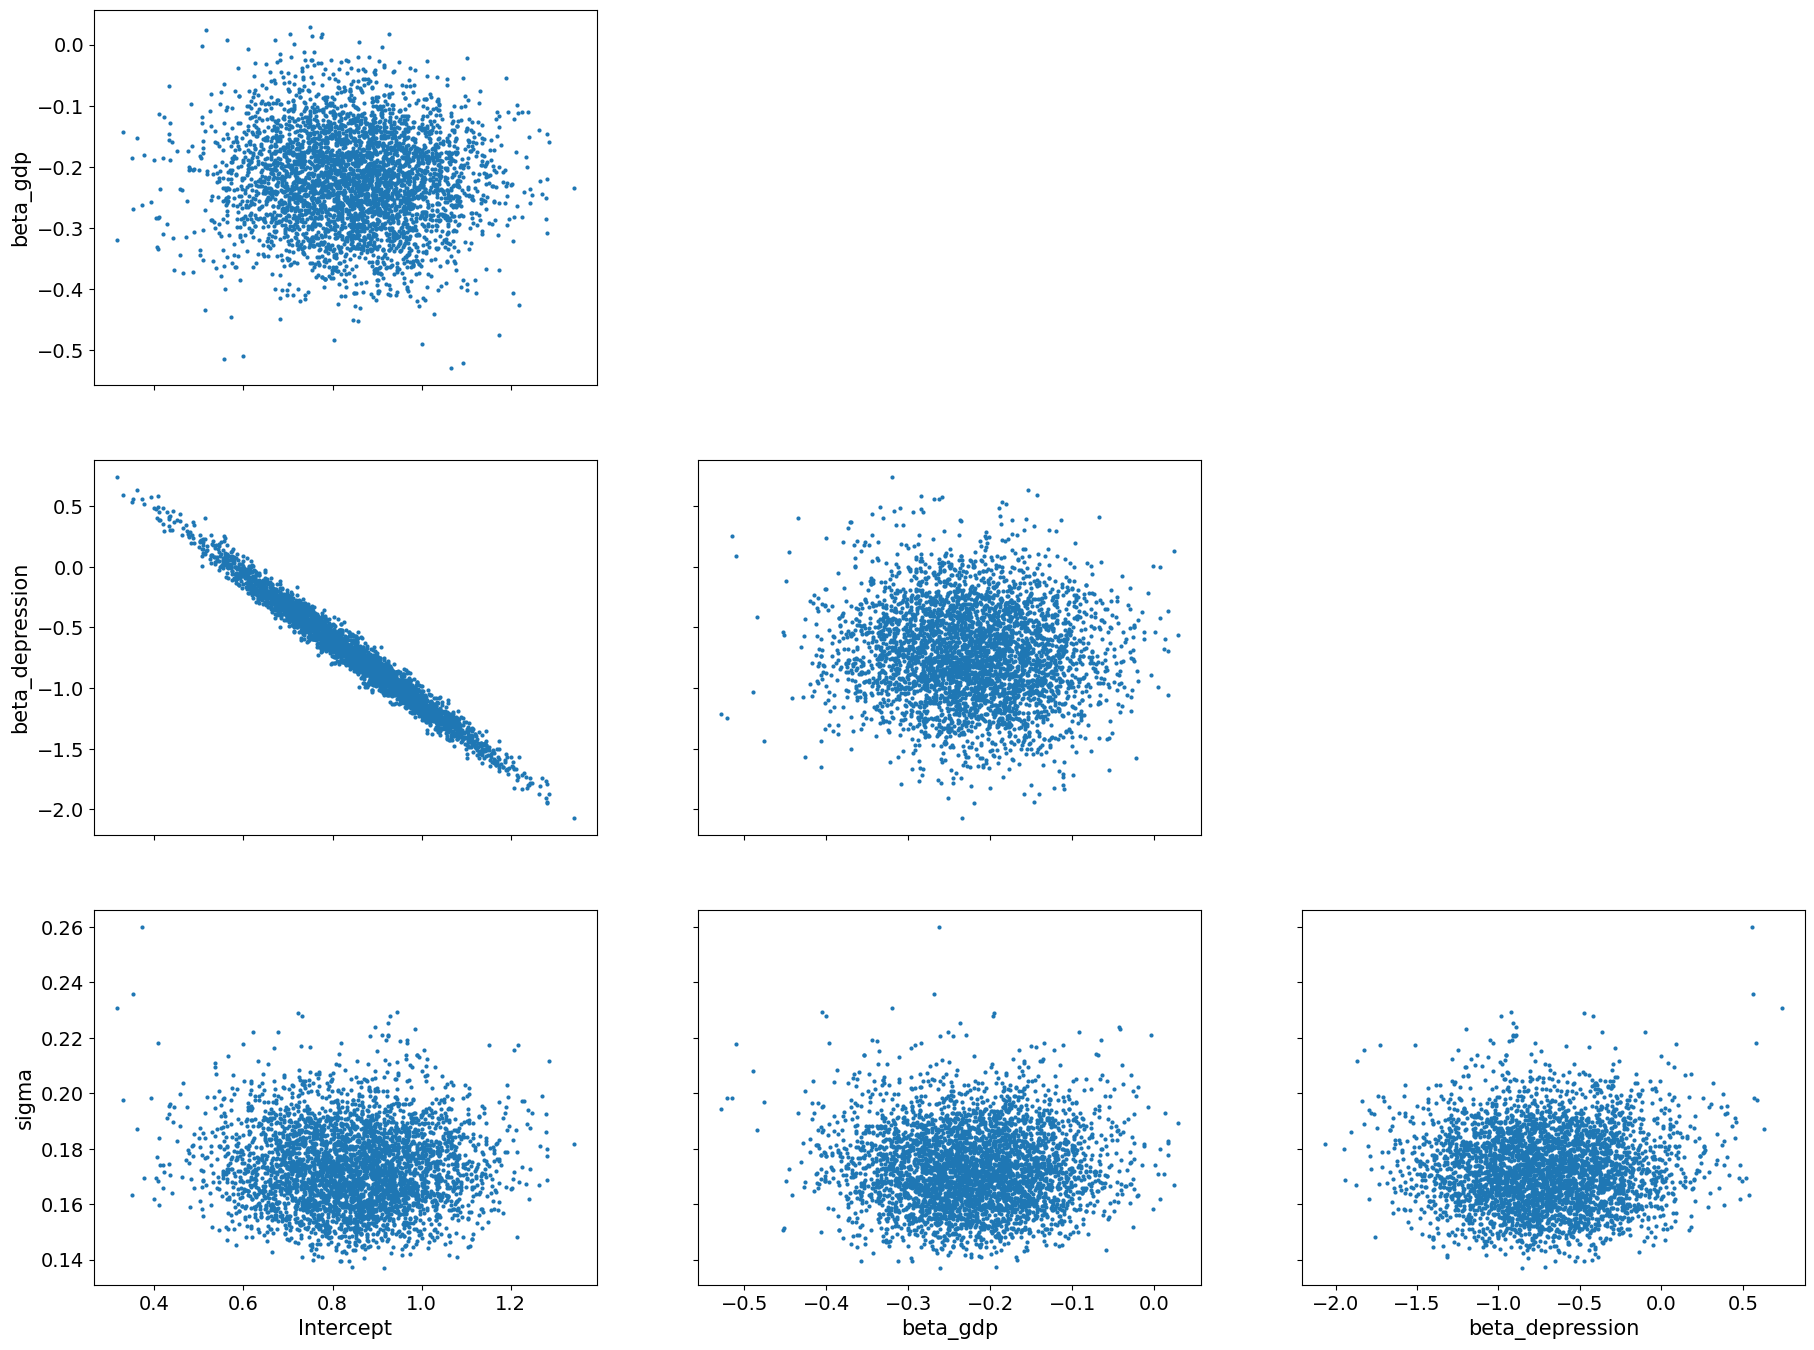

In [187]:
az.plot_pair(trace_model_all, var_names=['Intercept', 'beta_gdp', 'beta_depression', 'sigma'])

In [83]:
# Assuming 'sorted_data' is a Pandas DataFrame and the columns are in the order you've specified earlier
train, test = train_test_split(sorted_data, test_size=0.2, random_state=42)

# For training
train_X = train[['Suicide Rate', 'Depression Rate in %']].values  # Predictors
train_Y = train['GDP (million)'].values  # Outcome variable (GDP)

# For testing
test_X = test[['Suicide Rate', 'Depression Rate in %']].values
test_Y = test['GDP (million)'].values


In [96]:
from sklearn.preprocessing import StandardScaler

X = sorted_data[['Region', 'Year', 'Suicide Rate', 'Depression Rate in %']].values
y = sorted_data['GDP (million)'].values

# It's usually a good idea to standardize the features for regression models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [97]:

with pm.Model() as GDP_model:
    # Priors for the coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    coeffs = pm.Normal('Coeffs', mu=0, sigma=1, shape=X.shape[1])

    # Linear combination of features and coefficients
    expected_gdp = intercept + pm.math.dot(X_scaled, coeffs)

    # Likelihood of observations
    sigma = pm.HalfCauchy('sigma', beta=1)
    observed_gdp = pm.Normal('observed_gdp', mu=expected_gdp, sigma=sigma, observed=y)

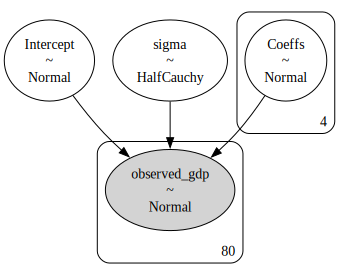

In [192]:
pm.model_to_graphviz(GDP_model)

In [98]:
with GDP_model:
    trace_GDP_model = pm.sample(1000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Coeffs, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.193  0.027   0.144    0.246      0.000    0.000    5623.0   
Coeffs[0]  0.048  0.030  -0.006    0.105      0.000    0.000    5058.0   
Coeffs[1]  0.003  0.034  -0.057    0.068      0.001    0.001    3579.0   
Coeffs[2] -0.066  0.033  -0.130   -0.005      0.001    0.000    4070.0   
Coeffs[3] -0.024  0.033  -0.089    0.036      0.001    0.000    4038.0   
sigma      0.245  0.021   0.208    0.284      0.000    0.000    3787.0   

           ess_tail  r_hat  
Intercept    3314.0    1.0  
Coeffs[0]    3172.0    1.0  
Coeffs[1]    3102.0    1.0  
Coeffs[2]    2929.0    1.0  
Coeffs[3]    2992.0    1.0  
sigma        2847.0    1.0  


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Coeffs\n0'}>,
        <Axes: title={'center': 'Coeffs\n1'}>],
       [<Axes: title={'center': 'Coeffs\n2'}>,
        <Axes: title={'center': 'Coeffs\n3'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

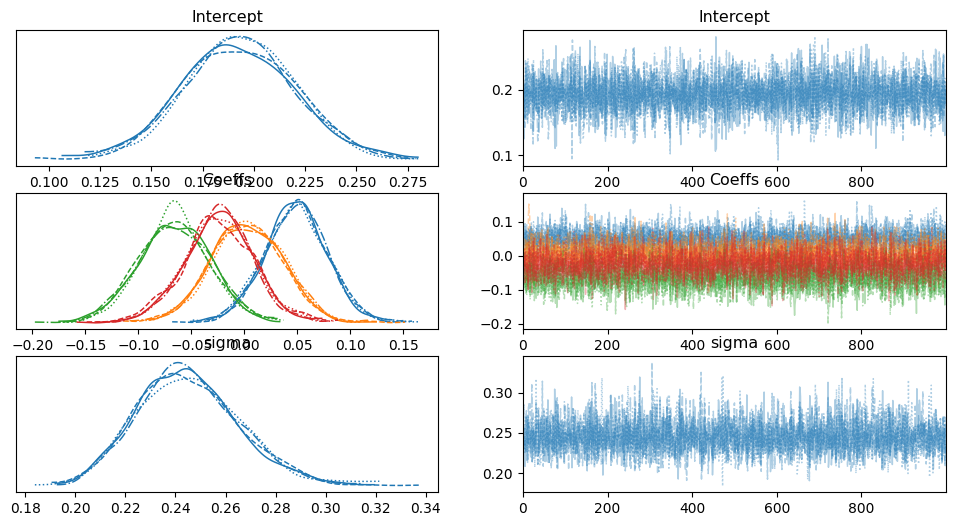

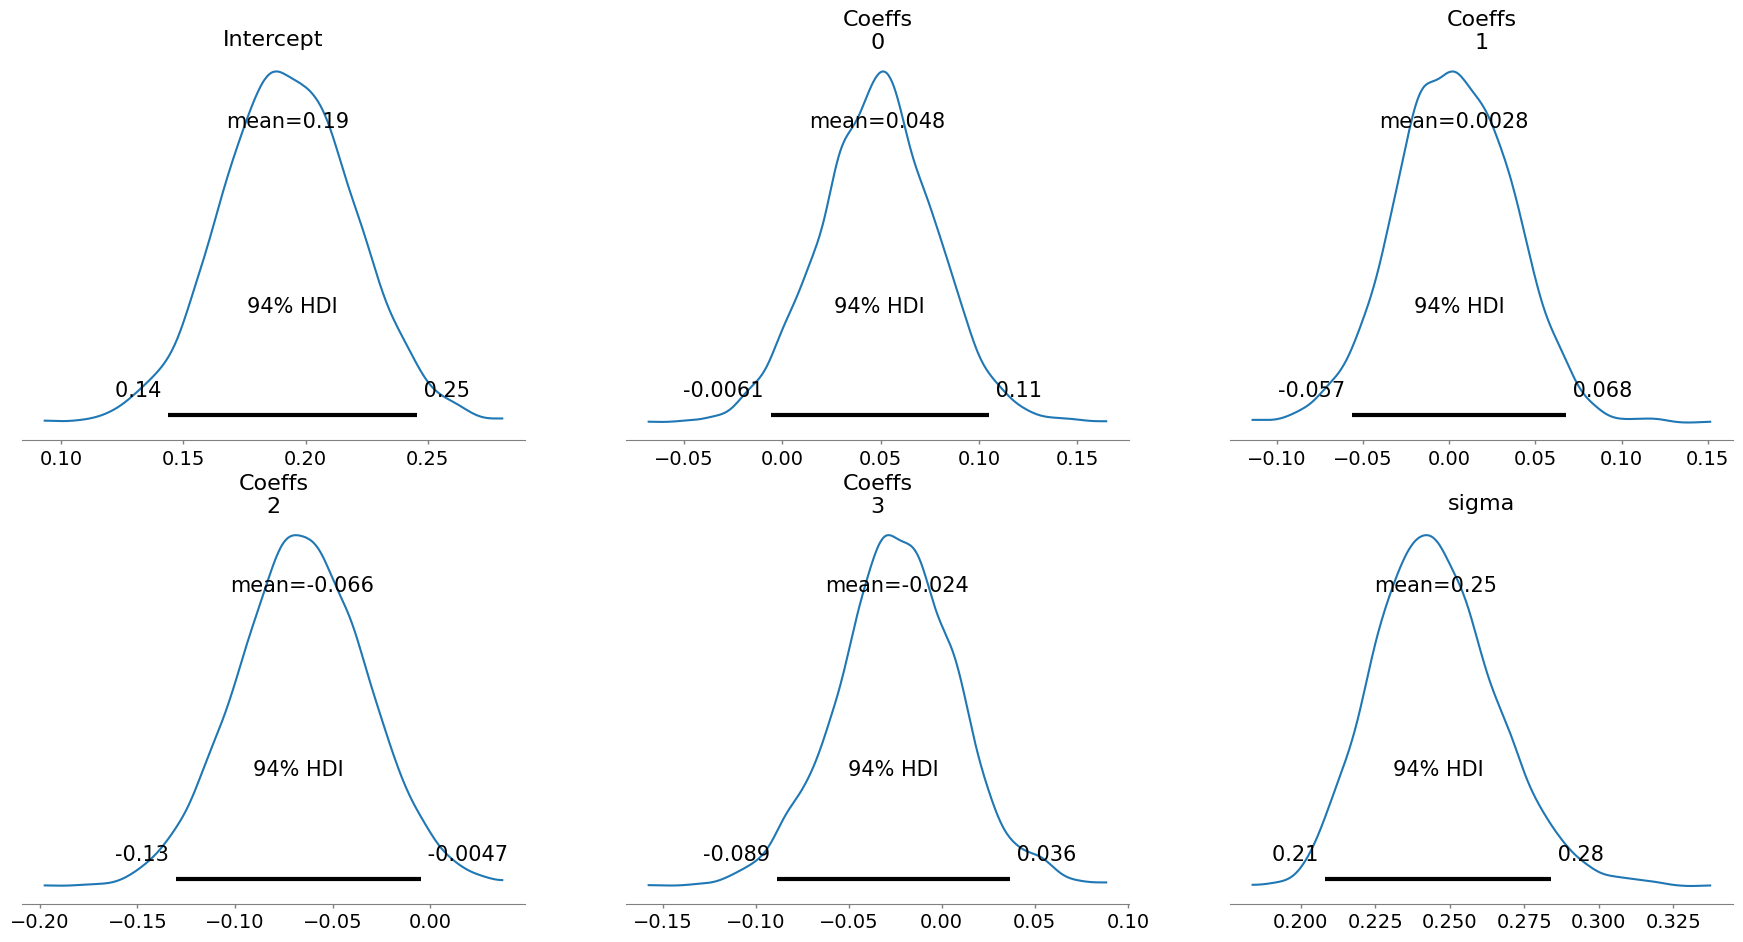

In [99]:
# Plotting the posterior distributions of the coefficients
az.plot_trace(trace_GDP_model)

# Summary statistics for the posterior distributions
print(az.summary(trace_GDP_model))

# Checking for model convergence and fit
az.plot_posterior(trace_GDP_model)

In [101]:
with GDP_model:
    # Sample from the posterior
    post_pred = pm.sample_posterior_predictive(trace_GDP_model)

Sampling: [observed_gdp]


In [102]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [113]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [114]:
obsereved_GDP = post_pred.posterior_predictive.observed_gdp
obsereved_GDP

<xarray.DataArray 'observed_gdp' (chain: 4, draw: 1000, observed_gdp_dim_2: 80)>
array([[[ 3.36957568e-01,  4.44808446e-01,  3.56288921e-01, ...,
         -1.52356314e-02,  3.29094366e-01,  5.81229715e-01],
        [ 2.42214679e-01, -1.03217025e-01,  5.57631728e-01, ...,
          1.70011386e-01,  3.61853777e-01,  1.33237713e-01],
        [ 9.97808521e-02,  1.50072340e-01, -1.23624482e-01, ...,
          1.71860370e-01,  2.99957872e-01,  5.85463723e-01],
        ...,
        [ 4.60470916e-01, -4.14315281e-01, -8.75993846e-02, ...,
          2.68192515e-01,  2.39044996e-01,  2.08206457e-01],
        [-1.37572260e-01, -2.77867514e-01, -1.82913652e-01, ...,
          3.47144278e-02,  4.20589064e-01,  2.73067158e-01],
        [ 4.76198392e-01,  2.08982961e-01, -1.66015628e-01, ...,
          1.73298988e-02,  4.93119156e-01,  3.02303775e-01]],

       [[ 5.59052208e-01,  8.23024668e-02,  1.78227698e-01, ...,
          2.59234449e-01,  2.90031484e-01,  1.11476560e+00],
        [-4.07005977e-02,  2.13839988e-01, -1.79279980e-01, ...,
          6.16666109e-01,  9.55569801e-02,  5.89720644e-01],
        [ 6.91650522e-01, -1.86885695e-01,  8.64899936e-03, ...,
         -4.86429319e-02,  2.05662135e-01,  5.60808522e-01],
...
        [-1.39203469e-01, -2.88676268e-01,  1.62375118e-02, ...,
          4.80534305e-02,  1.15089160e-01,  1.32637046e-01],
        [ 3.99480673e-01, -1.09587147e-01,  8.34803248e-02, ...,
          5.51375223e-01,  3.57356144e-01,  2.69236176e-01],
        [-9.09662202e-02, -1.82121507e-01, -1.52998404e-01, ...,
          2.98436114e-01,  1.95296320e-01,  8.74755553e-02]],

       [[ 2.81556636e-01, -1.52828997e-01,  6.77175512e-02, ...,
          5.01770500e-01,  4.02919161e-01,  2.05117560e-01],
        [ 5.29980561e-03,  3.17211598e-01, -1.43018454e-01, ...,
          5.16158990e-01,  3.40964107e-02,  1.52857229e-01],
        [ 7.60021787e-02, -3.74804625e-01,  7.74414866e-02, ...,
          4.05964224e-02, -2.22153494e-02,  3.37216910e-01],
        ...,
        [ 8.48716808e-02,  7.10552353e-02,  2.89902352e-01, ...,
          2.30569718e-01,  5.96206602e-01,  3.97264308e-01],
        [ 2.84994872e-03,  1.71588682e-01,  8.71177545e-02, ...,
          1.50577465e-01,  6.82202131e-01, -1.86274693e-02],
        [ 4.42166192e-02, -6.45778565e-02,  3.13630284e-01, ...,
          5.46433923e-01,  7.01495141e-02,  8.26768609e-01]]])
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * observed_gdp_dim_2  (observed_gdp_dim_2) int64 0 1 2 3 4 ... 75 76 77 78 79

In [109]:
# Calculate the mode of the posterior predictive samples for each observation
mode_pred2 = stats.mode(obsereved_GDP, axis=0).mode[0]

In [116]:
mode_pred2

array([ 2.48154925e-01, -1.52828997e-01, -3.20506097e-01,  6.48544524e-03,
       -3.05724937e-01, -2.42968543e-01, -1.63320983e-01, -3.57480312e-01,
       -9.05197525e-02, -2.41325249e-01, -1.76378247e-01, -2.67846347e-01,
       -5.99194601e-02, -4.31631511e-01, -1.74588553e-02,  4.06935139e-02,
       -5.14442736e-01, -5.31192907e-02, -1.83255807e-01,  1.45649315e-01,
        5.33680545e-03, -1.53015883e-01, -3.32315321e-01, -2.88034409e-01,
       -7.59209243e-02, -2.07132369e-01, -2.84184146e-01, -6.06844210e-02,
       -5.76078274e-02,  2.06220912e-01, -1.67482683e-01,  5.16527592e-02,
       -4.13840036e-01,  1.50568863e-01, -1.05327995e-01, -3.24818147e-01,
       -3.77620201e-02, -1.65981522e-01,  2.25272525e-01, -1.14386422e-01,
       -1.28700390e-02, -3.55549666e-01,  5.70397279e-03,  2.21746302e-04,
        6.31335131e-02, -4.78858814e-02, -2.43036481e-01,  1.50456140e-01,
       -1.31015868e-01, -1.28376829e-01, -3.57010792e-03, -2.63070145e-01,
       -9.40267322e-02,  

In [117]:
y

array([0.00860366, 0.01193809, 0.0125693 , 0.01619189, 0.01834623,
       0.02268236, 0.02962567, 0.03655524, 0.04378671, 0.04448653,
       0.34090784, 0.35453373, 0.35403974, 0.37275646, 0.38440639,
       0.41777814, 0.45530765, 0.48452165, 0.50415775, 0.49589714,
       0.0399034 , 0.04426697, 0.04352599, 0.04905593, 0.05440749,
       0.05977276, 0.06957023, 0.08105549, 0.0910039 , 0.0877518 ,
       0.00150941, 0.00120753, 0.        , 0.00290905, 0.00351282,
       0.00720402, 0.01594489, 0.02640101, 0.02708711, 0.0338383 ,
       0.05339206, 0.05963555, 0.06045886, 0.067114  , 0.07064054,
       0.0906334 , 0.10269499, 0.10302432, 0.10478072, 0.09233493,
       0.0906334 , 0.0973846 , 0.08031451, 0.07802294, 0.09450299,
       0.10386135, 0.11824195, 0.13452989, 0.1546188 , 0.16292058,
       0.6139607 , 0.62119216, 0.61615621, 0.62363467, 0.68675558,
       0.73284758, 0.7961606 , 0.86607388, 0.98958505, 1.        ,
       0.07691147, 0.08229047, 0.08167298, 0.08167298, 0.08167

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


array([[<Axes: ylabel='Coeffs\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Coeffs\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Coeffs\n2'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='Coeffs\n3'>,
        <Axes: xlabel='Coeffs\n0'>, <Axes: xlabel='Coeffs\n1'>,
        <Axes: xlabel='Coeffs\n2'>]], dtype=object)

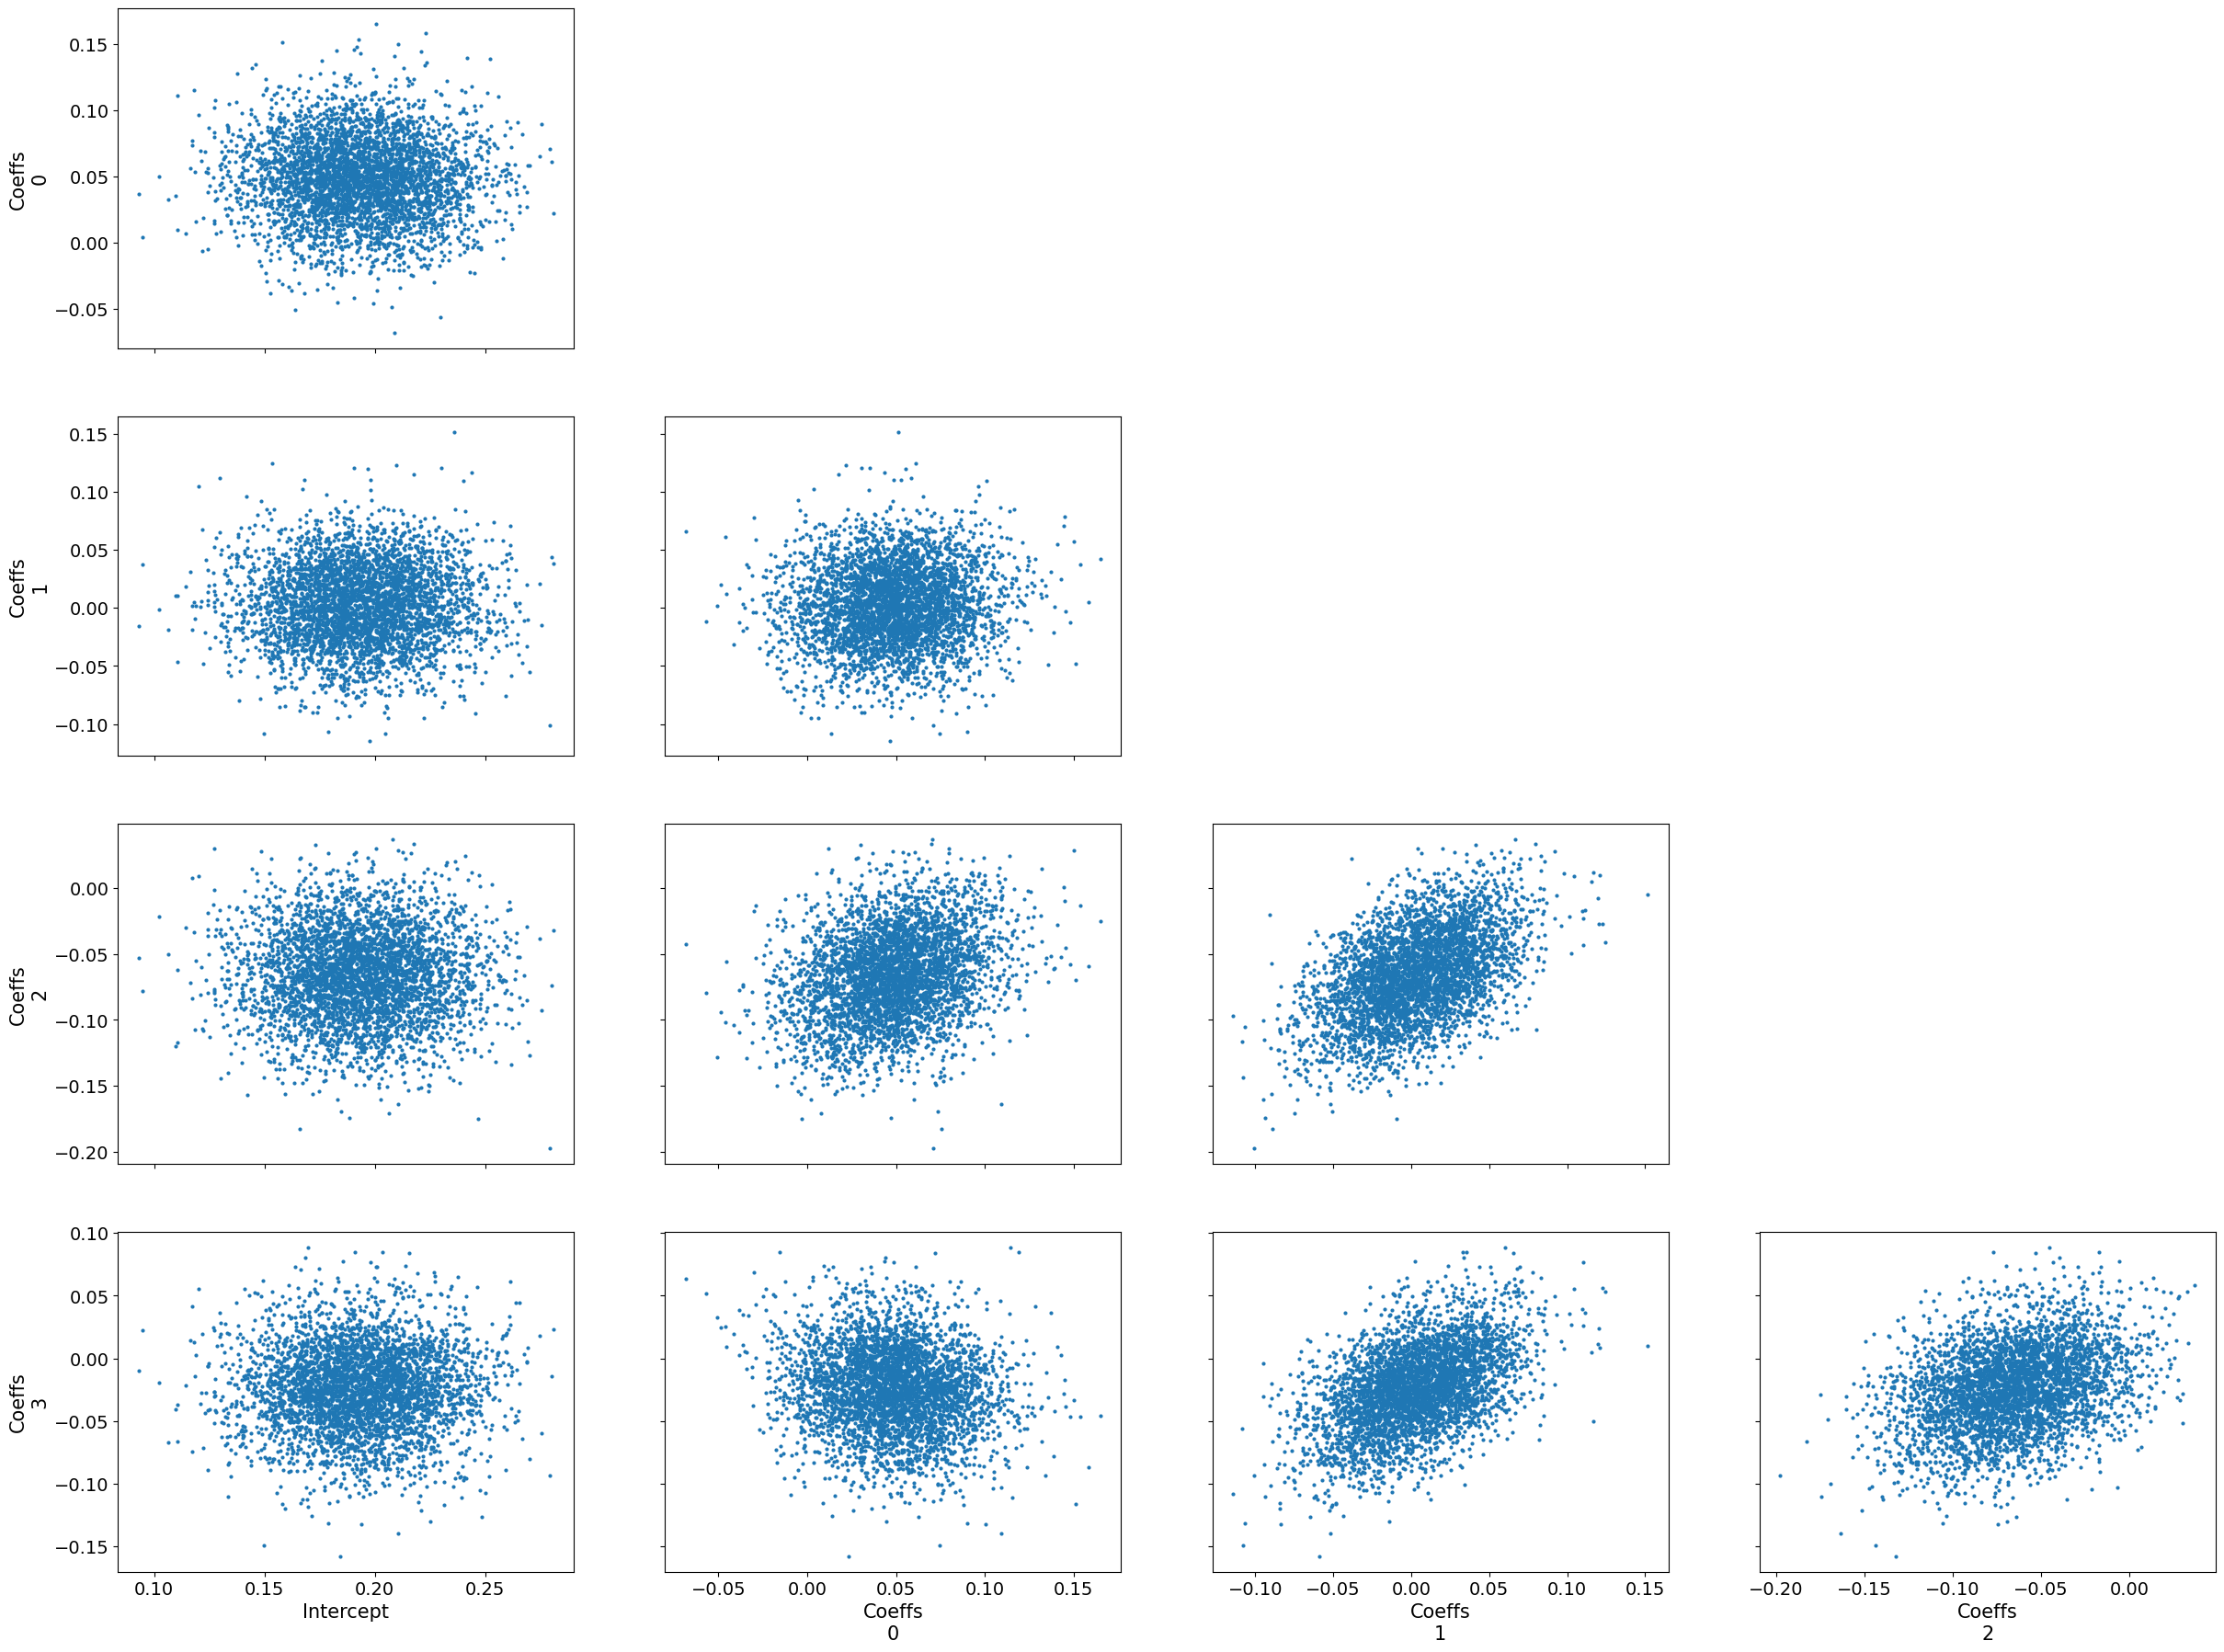

In [119]:
az.plot_pair(trace_GDP_model, var_names=['Intercept', 'Coeffs'])

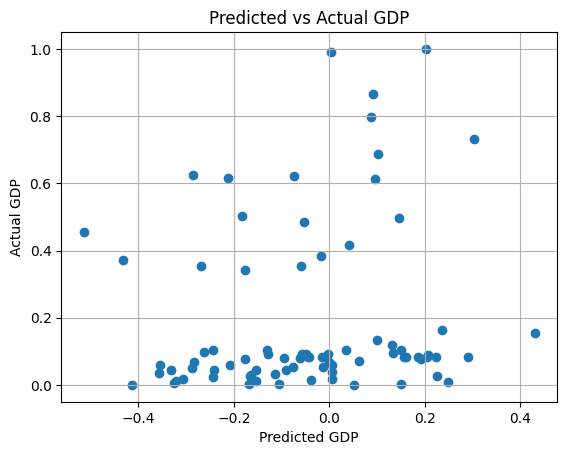

In [190]:
plt.scatter(mode_pred2, y)
plt.xlabel('Predicted GDP')
plt.ylabel('Actual GDP')
plt.title('Predicted vs Actual GDP')
plt.grid(True)
plt.show()